In [3]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting     




from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Cross validations 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance

# Scores

from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score  as r2                 # Metric
from sklearn.metrics import mean_squared_error as mse  

# Optimisation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Keras Model 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 
from matplotlib import cm
np.random.seed(1338)

# Optimization

from pyswarm import pso  

Using TensorFlow backend.


# Import Data

In [4]:
df1= pd.read_csv("Data.csv", index_col='Datetime', parse_dates=True) 
df2= pd.read_csv("Data2020.csv", index_col='Datetime', parse_dates=True)
df = pd.concat([df1,df2 ])

In [5]:
# shift inputs if needed here !

In [6]:
features=df
features.insert(1,"SMeanT",df.MeanT-df.SetTemp)  # Insert Output
features.SMeanT=features.SMeanT.shift(-1)       # Shift output by 1 place !

In [7]:
# Put Windows to end
windows=['Win_AFT', 'Win_AFB','Win_ARoof', 'Win_Akip', 'Win_BFT', 'Win_BFB', 'Win_Broof', 'Win_BKip','Vfloor_A','Vfloor_B']
features = features[ [ col for col in features.columns if col not in windows ] + windows ]
Names=list(features.columns)
unwanted = { 'group', 'WindD','SMeanT', 'WindDc','hourC','hourS','Rain','SetTemp','Spa','MeanC','WindDC_nan','WindDs'}
Xnames = [e for e in Names if e not in unwanted]
features['group'] = (features.index -features.index[0]).days

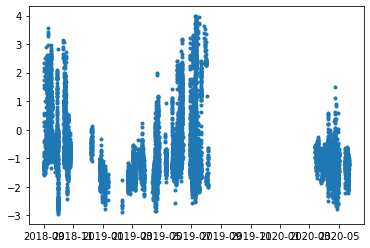

In [8]:
# Filter SMEANT 
features=features.loc[features.SMeanT.between(-3,4),:]
plt.plot(features.SMeanT,'.')

In [9]:
features=features.dropna(axis=0)

# Prapare Data 

In [10]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 40).split(features, groups=features['group']))

Train = features.iloc[train_inds]
Test = features.iloc[test_inds]

X = Train[Xnames].values
y = Train["SMeanT"].values  
print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X_test = Test[Xnames].values
y_test = Test["SMeanT"].values  
print("X.shape:  ", X_test.shape)
print("y.shape:  ", y_test.shape)

X.shape:   (9830, 19)
y.shape:   (9830,)
X.shape:   (3987, 19)
y.shape:   (3987,)


In [11]:
group=Train.group
n_splits=5
cv=GroupShuffleSplit(n_splits,random_state=24) 
ng=len(np.unique(features["group"].values))

# Hyperparameter Tuning

In [12]:
#'kerasregressor__neurons': 50, 'kerasregressor__epochs': 50, 'kerasregressor__batch_size': 5

def create_model(neurons=50):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_dim=X.shape[1], activation='relu'))
	model.add(Dense(1))
	model.compile(optimizer='adam',loss='mean_squared_error' )
	return model


model =make_pipeline(StandardScaler(), KerasRegressor(build_fn=create_model, verbose=0, batch_size=5,epochs=50))
model.fit(X,y)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kerasregressor',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x00000193A5239508>)],
         verbose=False)

# ANN

0.898597344045782


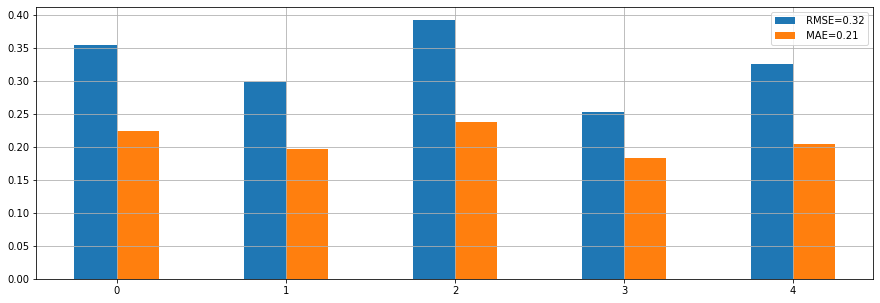

In [13]:
ANN =model

scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

scor= cross_validate(ANN, X, y, group, cv =cv,scoring=scoring)

mse1 = -scor['test_mse']
mae1 = -scor['test_mae']
r21=  -scor['test_r2']

labels = ['0','1', '2', '3', '4']
mse1 = np.sqrt(-scor['test_mse'])
mae1 = -scor['test_mae']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, mse1, width, label=" RMSE=%.2f"%(np.mean(mse1)),)
rects2 = ax.bar(x + width/2, mae1, width, label=" MAE=%.2f"%(np.mean(mae1)),)
plt.legend()
plt.grid()
print(np.mean(scor['test_r2']))

C:\Users\au327049\Conda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\au327049\Conda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


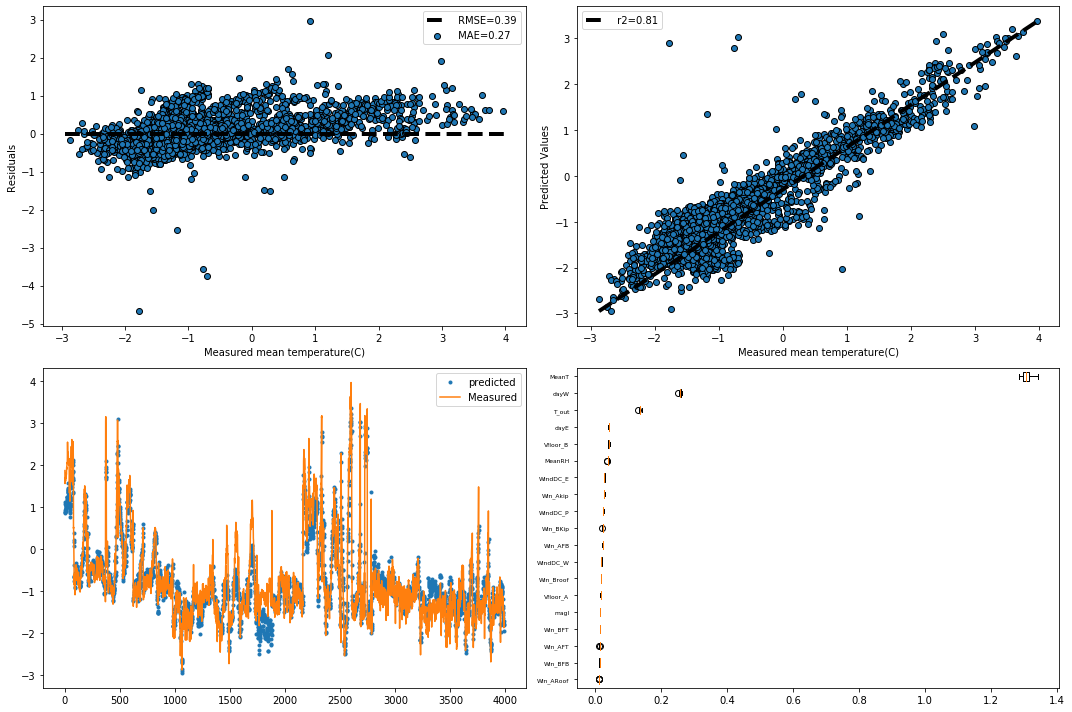

In [14]:
Y_pt=ANN.predict(X_test)

mse1 = mse(Y_pt,y_test)
mae1 = mae(Y_pt,y_test)
r21=  r2(Y_pt,y_test)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(y_test,y_test-Y_pt, edgecolors=(0, 0, 0), label=" MAE=%.2f"%(mae1),)
plt.plot([y.min(),y.max()], [0,0], 'k--', lw=4, label=" RMSE=%.2f"%(np.sqrt(mse1)),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Residuals')
plt.legend()


plt.subplot(2,2,2)
plt.scatter(y_test,Y_pt, edgecolors=(0, 0, 0))
plt.plot([y_test.min(),y_test.max()], [Y_pt.min(),Y_pt.max()], 'k--', lw=4,label=" r2=%.2f"%(r21),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Predicted Values')
plt.legend()


ax=plt.subplot(2,2,3)
plt.plot(Y_pt,'.',label="predicted",)
plt.plot(y_test,label="Measured")
plt.legend()

import eli5
from eli5.sklearn import PermutationImportance

ax=plt.subplot(2,2,4)
feature_names = np.r_[Xnames]
result = permutation_importance(ANN, X, y, n_repeats=20,
                               random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False)
ax.set_yticklabels(labels=feature_names[sorted_idx], minor=False,fontsize=6)
plt.tight_layout()
plt.show()  

# Optimize Here 

In [15]:
not_inds, use_inds = next(GroupShuffleSplit(test_size=.3, n_splits=2, random_state = 40).split(Test, groups=Test['group']))
use = Test.iloc[use_inds]
X_use = use[Xnames].values
y_use = use["SMeanT"].values 
print("X.shape:  ", X_use.shape)
print("y.shape:  ", y_use.shape)

X.shape:   (1208, 19)
y.shape:   (1208,)


In [16]:
# Function to get original value 
def weight2(x,args):
        p=np.concatenate((args,x))
        return (ANN.predict(p.reshape(1, -1)))    
    
def weight(x,args):
        p=np.concatenate((args,x))
        return np.square(ANN.predict(p.reshape(1, -1)))
    

In [17]:
from pyswarm import pso          

def FindOpimumANN(GiveX):    
    
   # lb=[0,0,0,0,0,0,0,0,max(0,X_use[GiveX,17]/1.2),max(0,X_use[GiveX,18]/1.05)]  
   # lb= np.maximum([0,0,0,0,0,0,0,0,0,0], X_use[GiveX,9:19]/1.4)
   
    lb=np.maximum([0,0,0,0,0,0,0,0], X_use[GiveX,9:17]/1.4)
    b=[max(0,X_use[GiveX,17]/1.2),max(0,X_use[GiveX,18]/1.1)]
    lb=np.append(lb, b, axis=0)

    ub= np.minimum([12.1,16,18,24.2,12.1,16,18,24.2], (X_use[GiveX,9:17]*1.4+0.1))
    c=min(X_use[GiveX,17]*1.1,17000),min(X_use[GiveX,18]*1.1,9000)
    ub=np.append(ub,c)

    #ub=[12.1,16,18,24.2,12.1,16,18,24.2,min(X_use[GiveX,17]*1.2,17000),min(X_use[GiveX,18]*1.05,9000)]  # Upper bounds for all controllable units 
    #ub= np.minimum([12.1,16,18,24.2,12.1,16,18,24.2,17000,90000], (X_use[GiveX,9:19]*1.4+0.1))
    x=X_use[GiveX,9:19]

    args=[X_use[GiveX,[0,1,2,3,4,5,6,7,8]]]
    
    xopt, fopt = pso(weight, lb, ub, args=args, swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=300, minstep=1e-8,
    minfunc=1e-8, debug=False)
    
    y_pre1= np.sqrt(fopt)
    OpV=weight2(xopt,X_use[GiveX,[0,1,2,3,4,5,6,7,8]])
    y_pre= weight2(X_use[GiveX,9:19],X_use[GiveX,[0,1,2,3,4,5,6,7,8]])
    y_ori= y_use[GiveX]
    return [OpV, y_pre, y_ori, xopt,y_pre1];

In [18]:
OpV_list=[]
y_pre_list=[]
y_pre1_list=[]
y_ori_list=[]
x_opt_list=[]
x=np.arange(0,len(X_use)-1)
#x=np.arange(1,30)

for i in x:
    OpV, y_pre, y_ori,xopt,y_pre1 = FindOpimumANN(i)
    OpV_list = np.append(OpV_list, [OpV])
    y_pre_list = np.append(y_pre_list, [y_pre])
    y_ori_list = np.append(y_ori_list, [y_ori])
    x_opt_list = np.append(x_opt_list, [xopt])
    y_pre1_list=np.append(y_pre1_list, [y_pre1])

Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping search: maximum iterations reached --> 300
Stopping sea

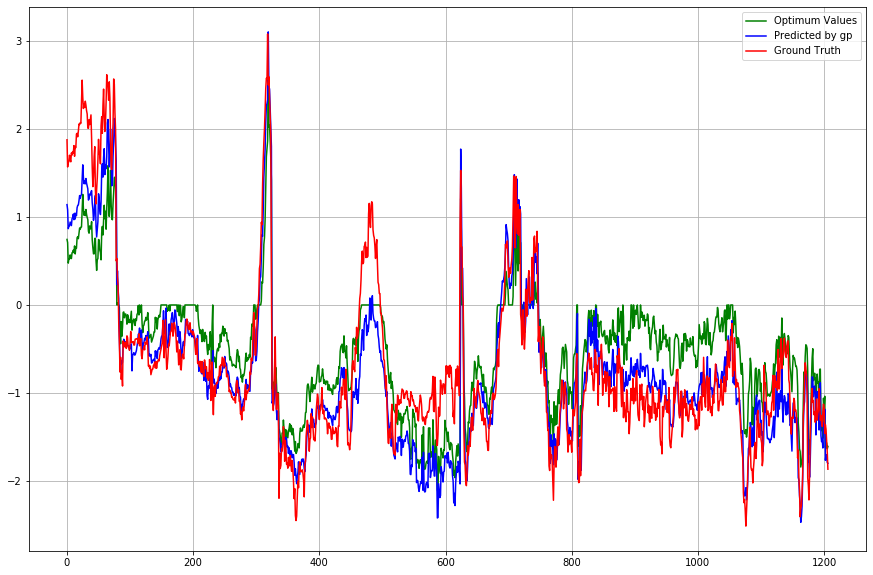

In [19]:
plt.figure(figsize=(15,10))
plt.plot(OpV_list,'g',label='Optimum Values')
plt.plot(( y_pre_list),'b',label='Predicted by gp')
plt.plot((y_ori_list),'r',label='Ground Truth')
#plt.plot((y_pre1_list),'k',label='Op2')
plt.legend()
plt.grid()

In [20]:
A=np.array([[OpV_list],[y_pre_list],[y_ori_list] ])
A=np.squeeze(A)
A=np.transpose(A)
print(A.shape)
A=np.append(A, np.reshape(x_opt_list,[len(x),10]), axis=1)
print(A.shape)
np.savetxt("ANN_Model.csv", A, delimiter=',', header="Optimum,Prediction,GroundTruth,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10", comments="")

(1207, 3)
(1207, 13)


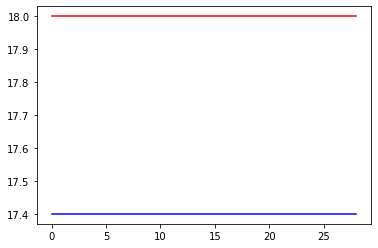

In [21]:
plt.plot(A[1:30,5],'r')
p=use[Xnames[11]].values
plt.plot(p[1:30],'b')


In [22]:
OptimumX=np.reshape(x_opt_list,[len(x),10])
OptimumX.shape
OriginalX=use[Xnames[9:19]] # get original X


In [23]:
OptimumX=pd.DataFrame(OptimumX,columns=Xnames[9:19])
OptimumX['Datetime']=OriginalX.index[:-1]                       # Make dataframe of optimum X
OptimumX.set_index('Datetime', inplace=True)